# Gaussian XOR and Gaussian N-XOR Experiment

One key goal of progressive learning is to be able to continually improve upon past performance with the introduction of new data, without forgetting too much of the past tasks. This transfer of information can be evaluated using a variety of metrics; however, here, we use a generalization of Pearl's transfer-benefit ratio (TBR) in both the forward and backward directions.

As described in [Vogelstein, et al. (2020)](https://arxiv.org/pdf/2004.12908.pdf), the forward transfer efficiency of task $f_n$ for task $t$ given $n$ samples is:

$$FTE^t (f_n) := \mathbb{E} [R^t (f^{t}_n )/R^t (f^{<t}_n )]$$

If $FTE^t(f_n)>1$, the algorithm demonstrates positive forward transfer, i.e. past task data has been used to improve performance on the current task.

Similarly, the backward transfer efficiency of task $f_n$ for task $t$ given $n$ samples is:

$$BTE^t (f_n) := \mathbb{E} [R^t (f_n^{<t} )/R^t (f_n)]$$

If $BTE^t(f_n)>1$, the algorithm demonstrates positive backward transfer, i.e. data from the current task has been used to improve performance on past tasks.

Progressive learning in a simple environment can therefore be demonstrated using two simple tasks: Gaussian XOR and Gaussian Not-XOR (N-XOR). Here, forward transfer efficiency is the ratio of generalization errors for N-XOR, whereas backward transfer efficiency is the ratio of generalization errors for XOR. These two tasks share the same discriminant boundaries, so learning can be easily transferred between them.

This experiment compares the performance of lifelong forests to uncertainty forests in undergoing these tasks.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import functions.xor_nxor_functions as fn
from proglearn.sims import generate_gaussian_parity

Using TensorFlow backend.
C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\shizh\Anaconda3\envs\progl

**Note:** This notebook tutorial uses functions stored externally within `functions/xor_nxor_functions.py`, to simplify presentation of code. These functions are imported above, along with other libraries.

## Classification Problem

First, let's visualize Gaussian XOR and N-XOR.

Gaussian XOR is a two-class classification problem, where...
- Class 0 is drawn from two Gaussians with $\mu = \pm [0.5, 0.5]^T$ and $\sigma^2 = I$.
- Class 1 is drawn from two Gaussians with $\mu = \pm [0.5, -0.5]^T$ and $\sigma^2 = I$.

Gaussian N-XOR has the same distribution as Gaussian XOR, but with the class labels flipped, i.e...
- Class 0 is drawn from two Gaussians with $\mu = \pm [0.5, -0.5]^T$ and $\sigma^2 = I$.
- Class 1 is drawn from two Gaussians with $\mu = \pm [0.5, 0.5]^T$ and $\sigma^2 = I$.

Within the proglearn package, we can make use of the simulations within the `sims` folder to generate simulated data. The `generate_gaussian_parity` function within `gaussian_sim.py` can be used to create the Gaussian XOR and N-XOR problems. Let's generate data and plot it to see what these problems look like!

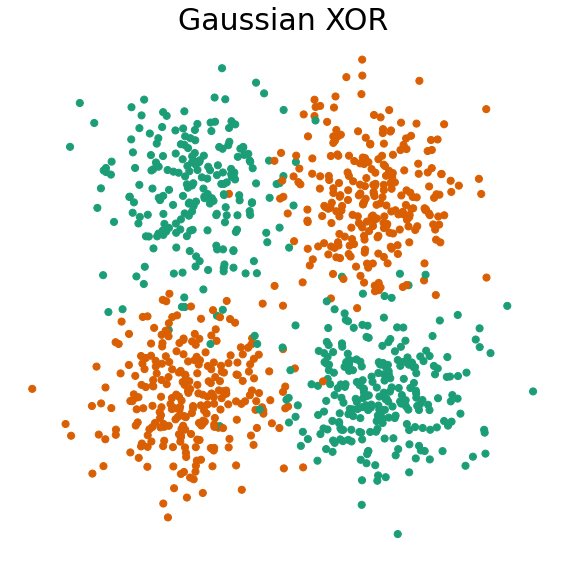

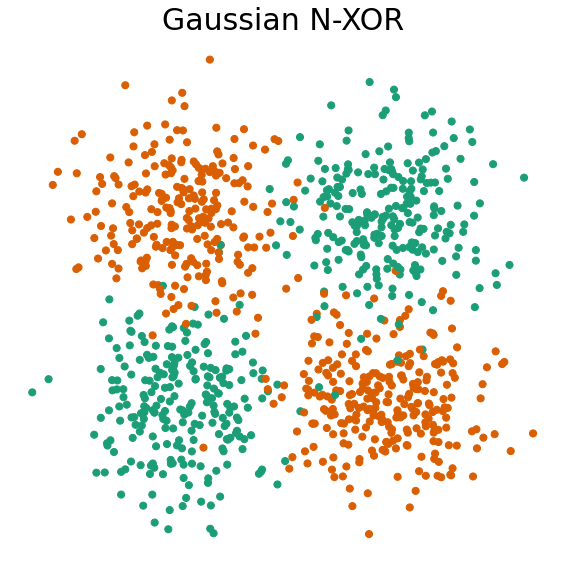

In [2]:
# call function to return gaussian xor and n-xor data:
X_xor, y_xor = generate_gaussian_parity(1000)
X_nxor, y_nxor = generate_gaussian_parity(1000, angle_params=np.pi/2)

X, Y = generate_gaussian_parity(750, angle_params=0)
Z, W = generate_gaussian_parity(750, angle_params=np.pi/2)

# plot and format:
fn.plot_xor_nxor(X_xor, y_xor, 'Gaussian XOR')
fn.plot_xor_nxor(X_nxor, y_nxor, 'Gaussian N-XOR')

## The Experiment

Now that we have generated the data, we can prepare to run the experiment. The function for running the experiment, `experiment`, can be found within `functions/xor_nxor_functions.py`. 

We first declare the hyperparameters to be used for the experiment, which are as follows:
- `mc_rep`: number of repetitions to run the progressive learning algorithm for
- `n_test`: number of xor/nxor data points in the test set
- `n_trees`: number of trees
- `n_xor`: array containing number of xor data points fed to learner, ranges from 50 to 725 in increments of 25
- `n_nxor`: array containing number of nxor data points fed to learner, ranges from 50 to 750 in increments of 25

In [3]:
# define hyperparameters:
mc_rep = 10 # 1000 in paper experiment
n_test = 1000 
n_trees = 10
n_xor = (100*np.arange(0.5, 7.25, step=0.25)).astype(int)
n_nxor = (100*np.arange(0.5, 7.50, step=0.25)).astype(int)

Once those are determined, the experiment can be initialized and performed. We iterate over the values in `n_xor` and `n_nxor` sequentially, running each experiment for the number of iterations declared in `mc_rep`.

In [4]:
# running the experiment:

# create empty arrays for storing results
mean_error = np.zeros((6, len(n_xor)+len(n_nxor)))
std_error = np.zeros((6, len(n_xor)+len(n_nxor)))
mean_te = np.zeros((4, len(n_xor)+len(n_nxor)))
std_te = np.zeros((4, len(n_xor)+len(n_nxor)))

# run the experiment
mean_error, std_error, mean_te, std_te = fn.run(mc_rep, n_test, n_trees,n_xor,n_nxor, mean_error, std_error, mean_te, std_te);

Great! The experiment should now be complete, with the results stored in four arrays: `mean_error`, `std_error`, `mean_te`, and `std_te`.

## Visualizing the Results

Now that the experiment is complete, the results can be visualized by extracting the data from these arrays and plotting it. 

Here, we again utilize functions from `functions/xor_nxor_functions.py` to help in plotting:
- `plot_error-and-eff`: plots generalization error and transfer efficiency for progressive learning and random forests

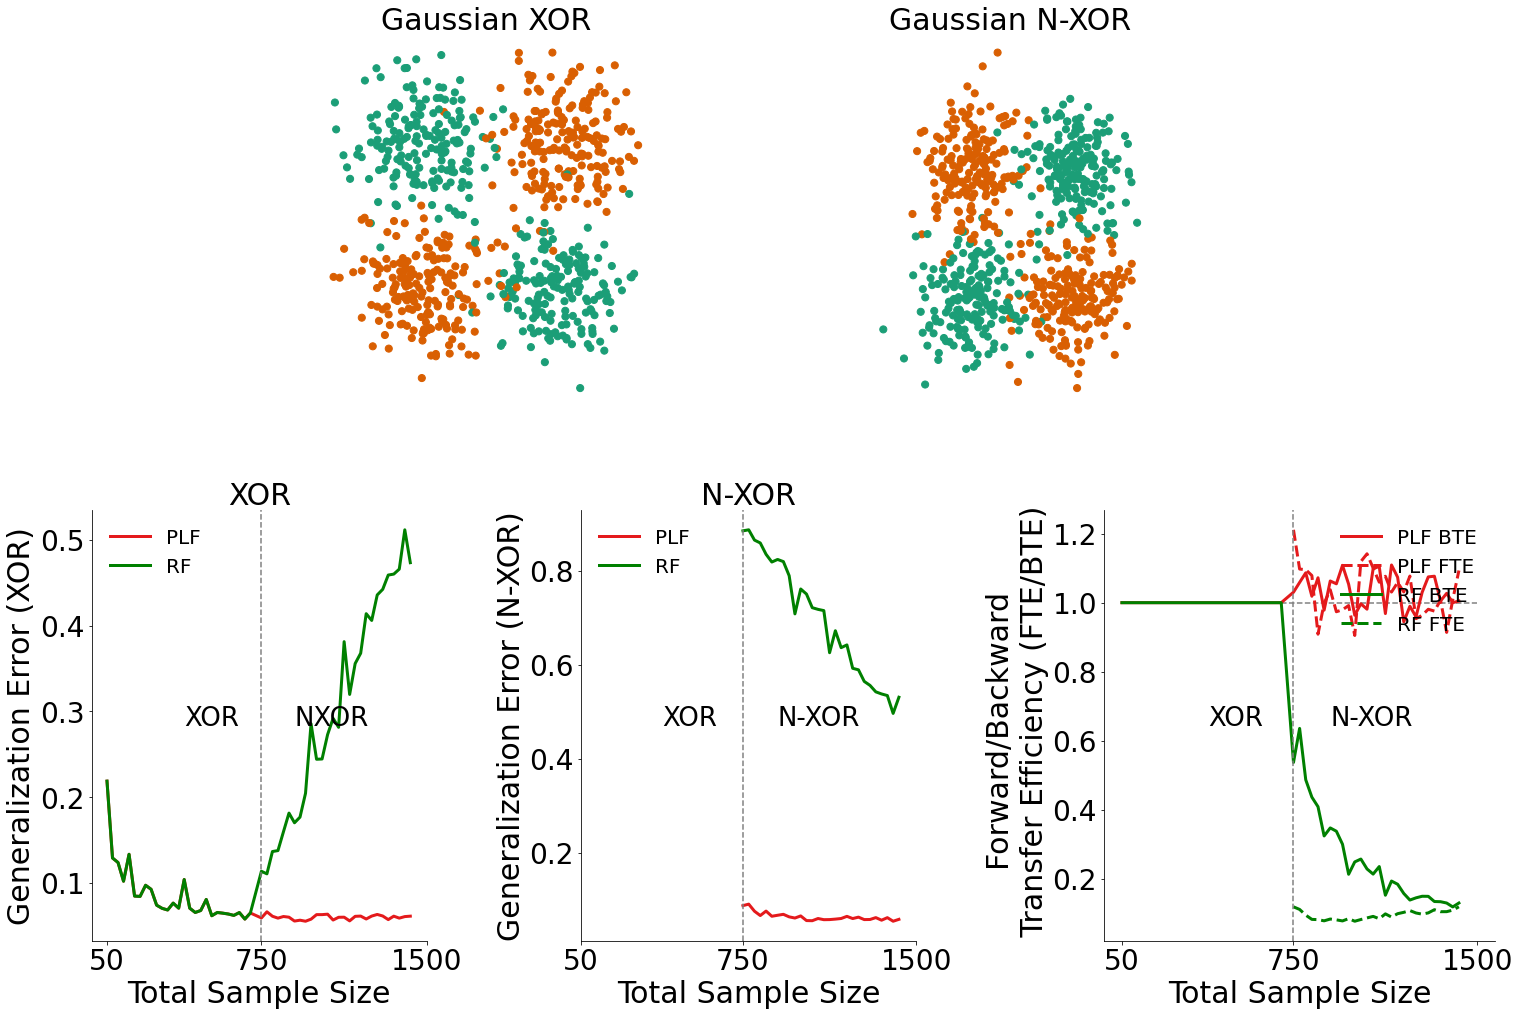

In [5]:
# plot data
fn.plot_error_and_eff(n_xor,n_nxor, mean_error, mean_te, 'XOR', 'NXOR')

Text(900, 0.2835000000000001, 'NXOR')

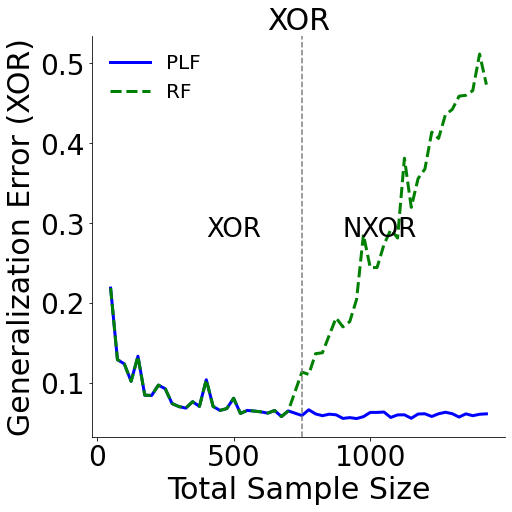

In [6]:
TASK1 = 'XOR'
TASK2 = 'NXOR'
ns = np.concatenate((n_xor, n_nxor + n_xor[-1]))
fontsize=30
labelsize=28

fig = plt.figure(constrained_layout=True,figsize=(7,7))

algorithms = ["XOR Forest", "N-XOR Forest", "PLF", "RF"]

plt.plot(ns, mean_error[1], label=algorithms[2], lw=3, c='b')
plt.plot(ns, mean_error[4], label=algorithms[3], ls="--", lw=3, c='g')

plt.ylabel('Generalization Error (%s)'%(TASK1), fontsize=fontsize)
plt.legend(loc='upper left', fontsize=20, frameon=False)

plt.xlabel('Total Sample Size', fontsize=fontsize)
plt.tick_params(labelsize=labelsize)

plt.axvline(x=750, c='gray', linewidth=1.5, linestyle="dashed")
plt.title('XOR', fontsize=30)

right_side = plt.gca().spines["right"]
right_side.set_visible(False)
top_side = plt.gca().spines["top"]
top_side.set_visible(False)

plt.text(400, np.mean(plt.ylim()), "%s"%(TASK1), fontsize=26)
plt.text(900, np.mean(plt.ylim()), "%s"%(TASK2), fontsize=26)

Text(0.5, 1.0, 'N-XOR')

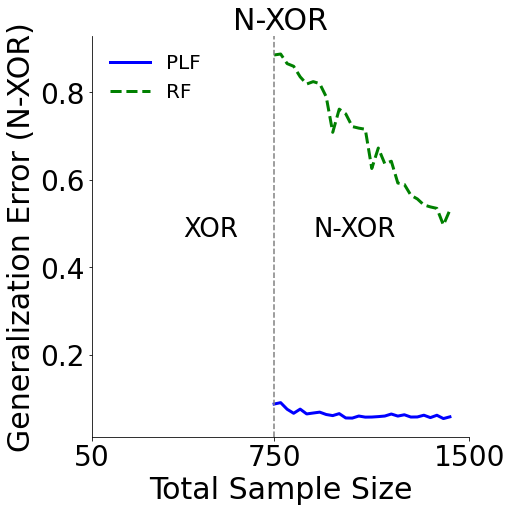

In [7]:
algorithms = ["XOR Forest", "N-XOR Forest", "PLF", "RF"]

ns = np.concatenate((n_xor, n_nxor + n_xor[-1]))
fontsize=30
labelsize=28

TASK1='XOR'
TASK2='N-XOR'

fig = plt.figure(constrained_layout=True,figsize=(7,7))
algorithms = ["XOR Forest", "N-XOR Forest", "PLF", "RF"]

plt.plot(ns[len(n_xor):], mean_error[3, len(n_xor):], label=algorithms[2], lw=3,  c='b')
plt.plot(ns[len(n_xor):], mean_error[5, len(n_xor):], label=algorithms[3], lw=3, ls="--",  c='g')

plt.ylabel('Generalization Error (%s)'%(TASK2), fontsize=fontsize)
plt.legend(loc='upper left', fontsize=20, frameon=False)
plt.xlabel('Total Sample Size', fontsize=fontsize)
plt.tick_params(labelsize=labelsize)
plt.xticks([50,750,1500])
plt.axvline(x=750, c='gray', linewidth=1.5, linestyle="dashed")


right_side = plt.gca().spines["right"]
right_side.set_visible(False)
top_side = plt.gca().spines["top"]
top_side.set_visible(False)

plt.text(400, np.mean(plt.ylim()), "%s"%(TASK1), fontsize=26)
plt.text(900, np.mean(plt.ylim()), "%s"%(TASK2), fontsize=26)

plt.title('N-XOR', fontsize=30)

Text(900, 0.6443146738383906, 'N-XOR')

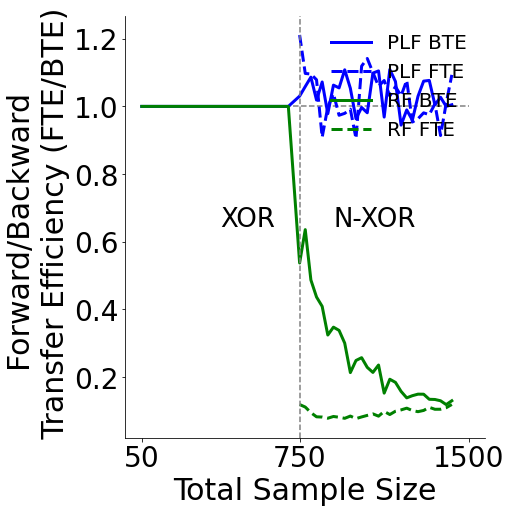

In [8]:
algorithms = ['PLF BTE', 'PLF FTE', 'RF BTE', 'RF FTE']

ns = np.concatenate((n_xor, n_nxor + n_xor[-1]))
fontsize=30
labelsize=28

TASK1='XOR'
TASK2='N-XOR'

fig = plt.figure(constrained_layout=True,figsize=(7,7))

plt.plot(ns, mean_te[0], label=algorithms[0], lw=3, c='b')
plt.plot(ns[len(n_xor):], mean_te[1, len(n_xor):], label=algorithms[1], lw=3,  c='b', ls='--')
plt.plot(ns, mean_te[2], label=algorithms[2], lw=3,  c='g')
plt.plot(ns[len(n_xor):], mean_te[3, len(n_xor):], label=algorithms[3], lw=3,  c='g', ls='--')

plt.ylabel('Forward/Backward \n Transfer Efficiency (FTE/BTE)', fontsize=fontsize)
plt.legend(loc='upper right', fontsize=20, frameon=False)
plt.xlabel('Total Sample Size', fontsize=fontsize)
plt.tick_params(labelsize=labelsize)
#ax1.set_yticks([0,.5,1,1.5])
plt.xticks([50,750,1500])
plt.axvline(x=750, c='gray', linewidth=1.5, linestyle="dashed")

right_side = plt.gca().spines["right"]
right_side.set_visible(False)
top_side = plt.gca().spines["top"]
top_side.set_visible(False)

plt.hlines(1, 50,1500, colors='gray', linestyles='dashed',linewidth=1.5)

plt.text(400, np.mean(plt.ylim()), "%s"%(TASK1), fontsize=26)
plt.text(900, np.mean(plt.ylim()), "%s"%(TASK2), fontsize=26)

In [9]:
split = [0.9, 0.9, 0.9]
ra = range(50)
if np.sum(split) > 1:
    print(ra, int(len(ra)), int(len(ra)) * 0.9)
    print(np.random.choice(ra, int(len(ra) * p), replace=False) for p in split)

range(0, 50) 50 45.0
<generator object <genexpr> at 0x0000016ECA5686C8>


#### Generalization Error for XOR Data (bottom left plot)

By plotting the generalization error for XOR data, we can see how the 
introduction of N-XOR data influenced the performance of both the progressive learning forest and the random forest. 

In the bottom left plot, we see that when N-XOR data is available, the progressive learning forest outperforms random forests.

#### Generalization Error for N-XOR Data (bottom middle plot)

Similarly, by plotting the generalization error for N-XOR data, we can also see how the presence of XOR data influenced the performance of both algorithms. 

In the bottom middle plot, we see that given XOR data is available, the progressive learning forest outperforms random forests on classifying N-XOR data.

#### Transfer Efficiency for XOR Data (bottom right plot)

Given the generalization errors plotted above, we can find the transfer efficiency as a ratio of the generalization error for progressive learning to random forests. The forward and backward transfer efficiencies are then plotted in the bottom right plot.

Progressive learning forests demonstrate both positive forward and backward transfer in this environment